# Unsupervised Learning for Cluster Analysis with Python and Sklearn

Unsupervised learning techniques are useful for data scientists and businesses for many reasons. For one, often times data scientists are given a dataset and instructed to build a model. Unsupervised learning models can assist the data scientist in finding existing patterns and relationships within the data. Other times, unsupervised learning can be useful for answering open ended questions for which there are no labels to use in supervised learning algorithms. This post will demonstrate how to to use unsupervised learning for the second case.

In this example you will learn:
- how to perform variable reduction with principal component analysis
- how to use a sklearn pipeline to standardize data processing
- how to perform k-means clustering
- how to plot geographical data

Let's say you just got hired as a data scientist (congratulations!) at Home World, a national retailer that sells everything you might need to take care of your home and yard. The leaders at Home World are not happy with their current distribution strategy. Some stores are running out of products to quickly, while others have excess inventory that isn't being sold. You are charged with creating a data-driven strategy that will ensure that the right products end up in the right stores at the right time.

First, you think you can solve this problem with supervised learning. I'll just get the inventory of each store for the past 10 years, forecast the demand for each type of product, and then I can tell my bosses how much of each product to send to each store. However, then you realize there are 2000+ stores, 5000+ products across all stores, and the Home World has switched database providers several times in the last 10 years. Maybe creating 1000000 models to cover all the store/product combinations and wrangling all the data isn't such a straight forward solution.

Instead, you decide to utilize unsupervised learning to cluster stores into similar groups. It is likely that similar stores will sell similar products. At the very least, you could make models to forecast inventory for 10 or 20 store clusters instead of 2000+ stores. 

Turns out that there is a dataset available that describes each of the Home World stores. We can use this to build a clustering model that groups similar stores together. Then we can focus on forecasting and determing the right product mix for each cluster.

Let's work through the process. 

The first step is to import the python modules we will need. The only one I'll point out is Basemap. We'll use this for plotting data on a map.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from mpl_toolkits.basemap import Basemap
import re

# Open data and handle missing values

In [2]:
data = pd.read_csv('data-prep-exercise-results.csv')
print(data.shape)
print('number of missing values: ', data.isnull().sum().sum())
# only one missing value, so will drop the row from the dataset
data = data.dropna(axis=0)
print(data.shape)
data.head()

(2127, 59)
number of missing values:  1
(2126, 59)


,StoreID,City,State,Date Last Winter Freeze,Date First Winter Freeze,Growing Season Length,Precip Jan,Precip Feb,Precip Mar,Precip Apr,...,Temp Aug,Temp Sep,Temp Oct,Temp Nov,Temp Dec,Elevation,Longitude,Latitude,LastWinterFreezeDiff,FirstWinterFreezeDiff
0,3772,Florida City,FL,2009-02-02,2010-01-14,361,1.192,1.272,4.202,2.588,...,81.50,80.88,77.28,72.51,67.88,6.29,-80.649351,25.360858,-80,100
1,3785,Miami,FL,2009-01-18,2010-02-03,362,1.012,2.182,2.738,4.568,...,83.60,82.40,78.80,74.40,69.90,6.56,-80.311200,25.736641,-95,120
2,3770,Miami Gardens,FL,2009-01-28,2010-01-13,365,0.996,2.344,2.818,3.856,...,84.78,83.63,80.18,75.86,71.36,6.79,-80.245486,25.949315,-85,99
3,3762,Hallandale Beach,FL,2009-01-26,2010-01-13,365,0.982,2.494,2.850,2.634,...,82.87,81.93,78.70,74.17,69.57,4.59,-80.148327,25.985698,-87,99
4,3725,Port Isabel,TX,2009-02-07,2009-12-28,363,1.320,1.046,1.260,1.016,...,83.49,81.17,76.20,69.24,61.44,8.50,-97.303707,26.025517,-75,83


The dataset contains information for all the Home World stores. Notable attributes include the StoreID, city, state, longitude, and latitude. The rest of the variables appear to describe the weather patterns around the store. Date Last Winter Freeze and Date First Winter Freeze provide information about when it gets cold in different environments; as does Growing Season Length. We can also see that there are monthly values for precipitation and temperature. Hidden between those columns are other weather types: snow and rain fall for each month. Any of these values could potentially prove useful for clustering, which gives lots of possible combinations to try. 

Most of the variables descibe the weather for the different months of the year. Rather than build our clustering algorithm, we can use principal component analysis to decompose the 12 months of data for each weather into latent variables that describe the variability contained within the 12 months of data. The latent variables are new representations of the data that explain the variance of the input data. The first principal componet will explain more of the variation than the last principal component. We'll visualize this a little further down to help understand the concept. You can get the technical math background [here](http://scikit-learn.org/stable/modules/decomposition.html#decompositions).

Programatically, we need to get the columns describing each weather pattern into their own array for the PCA decomposition.

# Get the columns to combine for the different component types

In [3]:
# get data for each weather type
# Precip
precip_data = data.loc[:, [x for x in data.columns if 'Precip' in x]]
# Rain
rain_data = data.loc[:, [x for x in data.columns if 'Rain' in x]]
# Snow
snow_data = data.loc[:, [x for x in data.columns if 'Snow' in x]]
# Temp
temp_data = data.loc[:, [x for x in data.columns if 'Temp' in x]]

# Make a pipeline for data transformations

It is helpful to scale the data before fitting the PCA. This is important because it means all our downstream features will have equal weight. If one month has values that are all near 0, and another month has values that are around 50, then it will any linear models based on those columns will be affected more by the column with larger values. They will effectivly mask any more subtle changes in the column with smaller values. Scaling each column means they will all be treated with equal weight. If you use a non-parametric model such as a decision tree or random forest, this not an issue.

We'll put our standard scaler and pca into a pipeline to keep everything neat and make future deployment easier.

In [4]:
# make a pipeline to handle scaling and PCA
scaler = StandardScaler()
pca = PCA()
data_pipeline = Pipeline([('scaler', scaler),('pca',pca)])

Now, we can pass each weather dataset through the pipeline and saved the transformed data. We'll also store the explained variance ratio so we can check how much each component is able to explain the original data.

# Transform

In [5]:
# use the pipeline on the each data
transformed_precip = data_pipeline.fit_transform(precip_data)
precip_var_ratios = data_pipeline.named_steps['pca'].explained_variance_ratio_
transformed_rain = data_pipeline.fit_transform(rain_data)
rain_var_ratios = data_pipeline.named_steps['pca'].explained_variance_ratio_
transformed_snow = data_pipeline.fit_transform(snow_data)
snow_var_ratios = data_pipeline.named_steps['pca'].explained_variance_ratio_
transformed_temp = data_pipeline.fit_transform(temp_data)
temp_var_ratios = data_pipeline.named_steps['pca'].explained_variance_ratio_

# Recombine the transformed data with the original df

Now we want to add our component columns back to the original dataframe for analysis and visualization.

In [6]:
def recombine_data(trans, df0, df1, col_name):
    cols = [col_name+str(x+1) for x in range(trans.shape[1])]
    df0.loc[:,:] = trans
    df0.columns = cols
    df1 = pd.concat([df1, df0], axis=1)
    return df1

In [7]:
data = recombine_data(transformed_precip, precip_data, data, 'Precip Comp')
data = recombine_data(transformed_rain, rain_data, data, 'Rain Comp')
data = recombine_data(transformed_snow, snow_data, data, 'Snow Comp')
data = recombine_data(transformed_temp, temp_data, data, 'Temp Comp')

I said above that PCA finds decomposes the input variables into latent variables that attempt the capture the variance of the input features in a smaller feature space. Let's visualize the effect of the PCA we did above to get a sense of that conceptually. The figure below plots the first and second principal components of the temperature data. I am ordering the data by the first principal component, and then overlay some the text indicating which state the data came from to help us interpret things.

When you look at the state abbreviations? On the left side are states that tend to have warmer temperatures, while on the right side the states tend to have colder temperatures (have you seen Fargo?). This shows us that the first principal component of the 12 months of temperature data seems to have caputured a latent variable relating to warmer and colder climates.

The second thing you will notice, is that there is no obvious relationship between PC1 and PC2. This is a property of the PCA dcomposition. Each component is orthogonal, so PC2 caputures a dimension that is unrelated to PC1. Pretty cool, huh?


# Principal Components are Orthogonal to Each Other

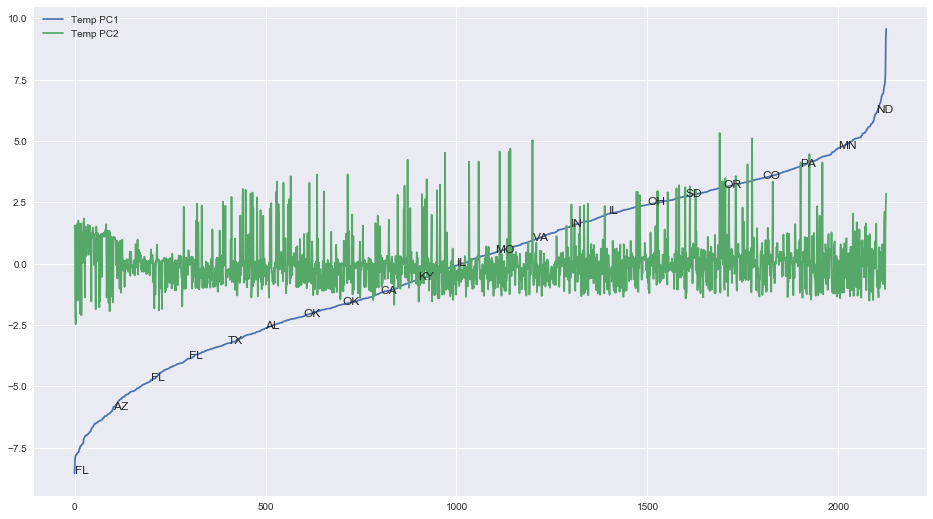

In [8]:
sorteddf = data.sort_values(by='Temp Comp1').reset_index()
fig, ax = plt.subplots(1, figsize=(16,9))
sorteddf['Temp Comp1'].plot(kind='line', use_index=False, ax=ax)
sorteddf['Temp Comp2'].plot(kind='line', use_index=False, ax=ax)
for count, s in enumerate(sorteddf['State']):
    if count % 100 == 0:
        ax.annotate(s, xy=(count, sorteddf['Temp Comp1'].loc[count]))
plt.legend(['Temp PC1', 'Temp PC2'])
plt.show();

The figure above does a good job of helping us understand how principal components relate to each other. However, what do these components tell us about our clustering problem? One way we can understand these components in the context of our problem is to visualize these components using a map. This will give us a view of how these components relate to where stores are located across the country.

c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


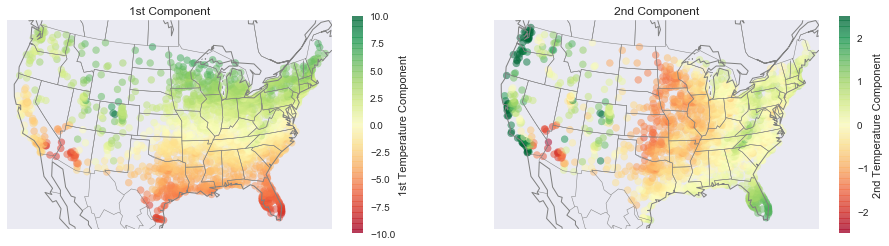

In [17]:
# Extract the data we're interested in
lat = data['Latitude'].values
lon = data['Longitude'].values
temppc1 = data['Temp Comp1'].values
temppc2 = data['Temp Comp2'].values

# 1. Draw the map background
fig, ax = plt.subplots(1, 2, figsize=(16,16))
ax[0].set_title("1st Component")
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95, ax=ax[0])

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
plt1 = m.scatter(lon, lat, latlon=True,
          c=temppc1, cmap='RdYlGn', alpha=0.5, vmin=-10, vmax=10)

# 3. create colorbar and legend
plt.colorbar(plt1, label=r'1st Temperature Component', ax=ax[0], shrink=0.25)
#plt.clim(-10,10)

ax[1].set_title("2nd Component")
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95, ax=ax[1])

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
plt2 = m.scatter(lon, lat, latlon=True,
          c=temppc2, cmap='RdYlGn', alpha=0.5, vmin=-2.5, vmax=2.5)

# 3. create colorbar and legend
plt.colorbar(plt2, label=r'2nd Temperature Component', ax=ax[1], shrink=0.25)
#plt.clim(-2.5,2.5)

plt.show()

The figure on the left shows the first temperature component mapped onto the continental United States. It's clear that the temperature component follows the latitude lines. Stores located further south have lower component scores and stores located further north have higher component scores. The graph on the right shows a different pattern for the second temperature component. Here, it looks like the components capture the difference between the center of the country and the coasts. Smaller component scores are in the middle of the country and larger component score are higher on the coasts.

The next step is to use the principal components cluster the stores. Instead of using all the components, we want to reduce the number. Otherwise, we end up with the same amount of features we started with. A typical rule of thumb is to choose the number of components that capture at least 80-90% of the total variance. Below, we plot the total cumulative variance as a function for each of the variables we performed PCA on.

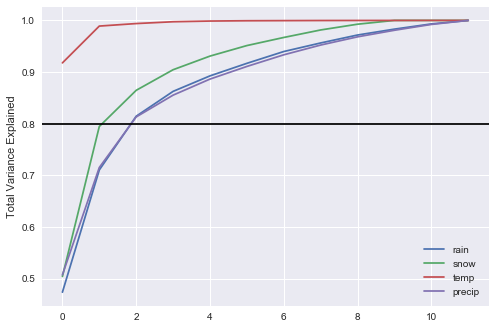

In [18]:
plt.plot(np.cumsum(rain_var_ratios))
plt.plot(np.cumsum(snow_var_ratios))
plt.plot(np.cumsum(temp_var_ratios))
plt.plot(np.cumsum(precip_var_ratios))
plt.axhline(0.8, c='k')
plt.legend(['rain','snow','temp','precip'])
plt.ylabel('Total Variance Explained')
plt.show()

Based on these results, I chose to use the first three components for all the different variable types. In practice, trying different combinations might lead to different results and is worth some experimentation.

The list comprehension quickly graphs the component columns ending with 1, 2, or 3.

In [19]:
cluster_data = data[[x for x in data.columns if re.search('Comp[123]$', x)]]
cluster_data.head()

,Precip Comp1,Precip Comp2,Precip Comp3,Rain Comp1,Rain Comp2,Rain Comp3,Snow Comp1,Snow Comp2,Snow Comp3,Temp Comp1,Temp Comp2,Temp Comp3
0,1.900455,-3.939185,0.874637,2.516979,-3.249076,1.318963,-1.376388,1.214244,-0.155745,-7.119460,1.833726,-0.500553
1,2.322156,-5.423938,1.195367,2.888469,-4.597341,1.979157,-1.376388,1.214244,-0.155745,-8.046950,1.550907,-0.455447
2,1.725209,-4.216764,1.258284,2.264950,-3.421322,1.891049,-1.376388,1.214244,-0.155745,-8.555415,1.465376,-0.429435
3,0.708201,-2.435387,1.428741,1.214714,-1.683193,1.829852,-1.376388,1.214244,-0.155745,-7.665125,1.749091,-0.468031
4,-2.123225,-1.263827,0.849837,-1.565505,-0.670323,1.057575,-1.374284,1.211069,-0.153619,-6.875191,0.725158,-0.477363


# K-mean Clustering

Now that we have our selected components, we can use the K-means algorithm to group them. At a high level, the K-means algorithm minimizes the within cluster sum of squares. Some things to keep in mind for K-means: it works poorly when the true clusters are irregularly shaped. Euclidean distances tend to be larger in higher dimensional spaces, so to many dimensions can impact performance - hence the variable reduction with PCA we are utilizing here. If you want to dive a little deeper, the [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html#k-means) is a good starting point. There are some nice images that demonstrate the weaknesses of K-means on known cluster types.

K-means also requires that we decide the number of clusters to solve for up front. Often we don't know how many clusters we should choose. To overcome this, we use the silhouette and Calinski-Harabaz scores to compare how differnt numbers of clusters affect the algorithm performance. Higher silhouette and Calinski-Harabaz scores indicate better defined clusters. From sklearn: "Calinski-Harabaz score s is given as the ratio of the between-clusters dispersion mean and the within-cluster dispersion". The silhouette score is calculated for each point and then averaged across all samples. The silhouette score uses the mean distance of a sample from all other samples in its cluster and compares it the mean distance of a sample from all the points in the next nearest cluster. More good information can be found [here](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) and [here](http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index). 

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabaz_score

# Create the clusters and evaluate

In [43]:
kscores = []
chscores = []
cluster_number = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for n_clusters in cluster_number:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(cluster_data)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(cluster_data, cluster_labels)
    ch_score = calinski_harabaz_score(cluster_data, cluster_labels)
    kscores.append(silhouette_avg)
    chscores.append(ch_score)

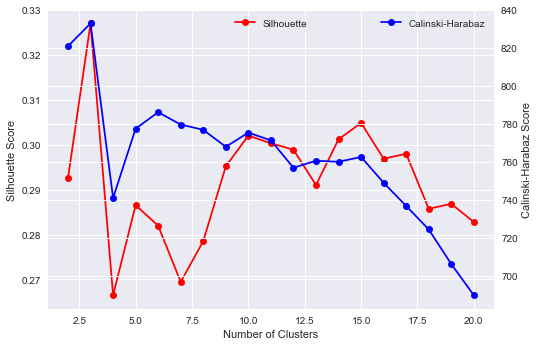

In [48]:
fig, ax = plt.subplots()
ax.plot(cluster_number, kscores, color='r', marker='o', label='Silhouette')
ax2 = ax.twinx()
ax2.plot(cluster_number, chscores, color='b', marker='o', label='Calinski-Harabaz')
ax.legend(loc=9)
ax2.legend()
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Calinski-Harabaz Score')
ax.set_xlabel('Number of Clusters')
plt.show();

The results our clustering attempts show that our best clusters are formed when we cluster using three groups. The silhouette score has a second peak when there are 15 clusters. Using the Calinski-Harabaz scores we could argue that six clusters is appropriate for our data. In this case, I'm going to force an assumption on the analysis from management: 3 clusters does not differentiate among stores enough to be useful for our inventory business problem. With this constraint, let's take a look at these 15 clusters in a way that we can start to gain some conceptual understanding of them. To do that, we will again plot the stores as points on a map, and the color of each point will represent the cluster to which that store belongs.

c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


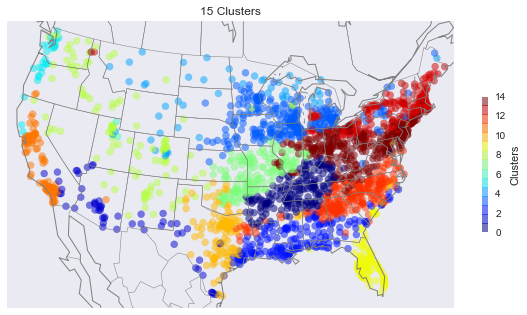

In [54]:
n_clusters = 15
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(cluster_data)

# Extract the data we're interested in
lat = data['Latitude'].values
lon = data['Longitude'].values

# 1. Draw the map background
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_title("{} Clusters".format(n_clusters))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95, ax=ax)

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter store data with color representing cluster
plt1 = m.scatter(lon, lat, latlon=True,
          c=cluster_labels, cmap=plt.cm.get_cmap('jet', n_clusters), alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(plt1, label=r'Clusters', ax=ax, shrink=0.25)
plt.show();

Looking at the data this way we can see how our weather input components grouped the stores into different regional clusters. You can conceptually imagine from these groupings how things like distance to coast, elevation, humidity, and snowfall create these regional clusters.

In addition to this conceptal understanding, we can compare the clusters based on the features we have in our dataset. Let's create a boxplot to compare the clusters by growing season length. These types of analyses give us concrete information describing the clusters.

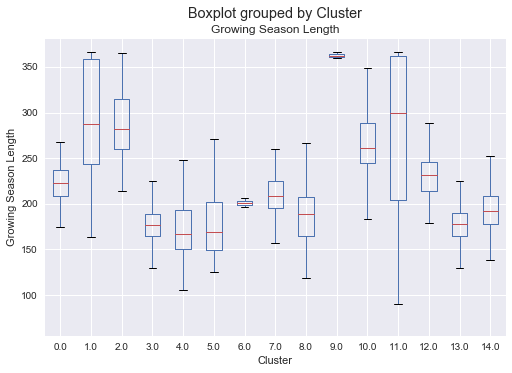

In [58]:
bplotdata = pd.concat([data['Growing Season Length'],pd.Series(cluster_labels)], ignore_index=True, axis=1)
bplotdata.columns = ['Growing Season Length', 'Cluster']
bplotdata.boxplot(column='Growing Season Length', by='Cluster')
plt.ylabel('Growing Season Length')
plt.show()

We can see from this plot that all the stores in cluster 9 have a growing season that lasts all year. Cluster 6 stores have a medium length growing season that is consistent for all the store locations. These kind of analyses on the clusters allows you as a data scientist to describe and better understand the clusters. Modeling the clusters is just the beginning. The business value comes from gaining a true understanding of the clusters.

Once we understand the clusters, we need to tell a story so that we can communicate our results back to the business stakeholders. In this instance, it might make sense to label the clusters with weather/regional names like  the Rainy Northwest, Tropical Florida, Southwest Desert, Cold As Canada, or The Rockies. These types of names can drive understanding of the clusters by associating stores with characteristics of their environment. If we had used demographic information for clustering, our cluster names would want to reflect that type of information - think soccer moms or weekend warriors.

In this post, you learned how to walk through an unsupervised clustering problem utilzing PCA, K-means, and plotting on maps. Try to apply some of these principles to your own dataset!